## 1. Create a Plant

The main class of `powerplantsim` is `Plant`, which defines a new power plant to simulate.
Its only parameter is the time horizon of the simulation; in this case, since we are passing an integer, the result will be an empty power plant ready to be run for `horizon` time steps.


In [1]:
import numpy as np
import pandas as pd

from powerplantsim import Plant

plant = Plant(horizon=7)
print(plant)

Plant('0X1A4B5D168F0'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: []
  > Edges: []


Rather than an integer value, it is also possible to pass a custom index. The constructor method accepts _lists_, _numpy arrays_, and _pandas series_.

Additionally, it is possible to provide a custom `name` for the plant, and a `seed` value which is used to build an internal random number generator.

In [2]:
plant_list = Plant(horizon=[0, 1, 2, 3, 4, 5, 6], name='List', seed=1)
print(plant_list)
print()

plant_array = Plant(horizon=np.arange(7), name='Array', seed=2)
print(plant_array)
print()

plant_series = Plant(horizon=pd.Series(range(7)), name='Series', seed=3)
print(plant_series)

Plant('List'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: []
  > Edges: []

Plant('Array'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: []
  > Edges: []

Plant('Series'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: []
  > Edges: []


## 2. Add Nodes

A `Plant` instance contains three main kind of nodes:
* _Extremities_, which can either supply or accept a single commodity;
* _Machines_, which can transform a single input commodity into one or more output commodities;
* _Storages_, which can store a single commodity.

The way to add a new node is via the `add_<type>` method, i.e., `add_extremity`, `add_machine`, or `add_storage`.

### 2.1. Suppliers

A `Supplier` node is an extremity node that can supply a single commodity.
In order to add a new `Supplier`, you need to use the `add_extremity` method with parameter `kind='supplier'`.
The rest of the parameters are:
* `name`, i.e., a unique identifier for the node in the plant;
* `commodity`, i.e., the name of the commodity which is supplied by the node;
* `predictions`, i.e., the vector of predicted prices for that commodity throughout the simulation;

> Note: since here we are passing a single float value as predicted vector, this will be converted in the array `[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]` -- the length of the array is _7_, as many as are the time steps of our simulation.

In [3]:
plant.add_extremity(
    kind='supplier',
    name='gas',
    commodity='gas',
    predictions=1.0
)

Supplier('gas')

Together with the predicted prices vector -- or constant --, it is possible to pass a variance model.

The variance $\Sigma$ is a custom distribution defining the difference between the predicted price $p_t$ and the actual value $v_t$ used in the simulation at time step $t$. This shift between prediction and value allows to model the intrinsic uncertainty of the problem, which usually relies on historical data to optimize the energetic plan of the power plant.

More specifically, the actual value $v_t$ is computed as:
$$v_t = p_t + \sigma_t, \sigma_t \sim \Sigma \mid v_{\{1:t-1\}}$$
namely, the distribution $\Sigma$ can be conditioned on the actual values computed in previous time steps.

> Note: from a programming perspective, the variance model is a function `f(rng, values)`, of which the actual values are the second parameter. The first parameter, instead, is a reference to the random number generator which is stored in the plant itself. It is advisable to use that random number generator instance to perform any random operation, in order to have completely reproducible results.

In [4]:
plant.add_extremity(
    kind='supplier',
    name='elec',
    commodity='elec',
    predictions=[1.4, 0.8, 2.3, 3.2, 1.8, 2.1, 1.5],
    variance=lambda rng, values: rng.normal(loc=0.0, scale=0.2)
)

Supplier('elec')

Every time a new node is added in the plant, this is not only returned by the `add_<type>` method, but also stored automatically within the plant itself.
We can see indeed that our plant now contains the two nodes that we just added.

In [5]:
print(plant)

Plant('0X1A4B5D168F0'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: [Supplier('gas'), Supplier('elec')]
  > Edges: []


### 2.2. Machines

A `Machine` node consumes a single commodity as input and produces one or more commodities as output.
Other than the usual `name`, a machine node needs:
* either a single or a list of `parents` that can provide its input commodity;
* the name of the input `commodity`;
* a `setpoint`, which defines the operative range of the machine;
* the `inputs`, i.e., a list of input commodity flows paired with the setpoint;
* the `outputs`, i.e., a list of flows paired with the setpoint and indexed by the name of the output commodity;

In [6]:
plant.add_machine(
    name='boiler',
    parents='gas',
    commodity='gas',
    setpoint=[0, 1],
    inputs=[0, 100],
    outputs={'heat': [0, 90]}
)

Machine('boiler')

Differently from `Supplier` nodes that are sources in the plant topology, `Machine` nodes must have parents.
Indeed, when printing the plant after our machine is added, we can see that an edge between the machine and its parent is automatically included as well.

In [7]:
print(plant)

Plant('0X1A4B5D168F0'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: [Supplier('gas'), Supplier('elec'), Machine('boiler')]
  > Edges: [('gas', 'boiler')]


Additionally, machines can be built with some additional parameters:
* `discrete`, i.e., whether the setpoint of the machine is discrete or continuous;
* `cost`, i.e., the cost of operating the machine during a time step;
* `max_starting`, i.e., a tuple ($N$, $T$) specifying that the machine can be started at most $N$ times in the past $T$ time steps.

In [8]:
plant.add_machine(
    name='cogen',
    parents='gas',
    commodity='gas',
    setpoint=[0.5, 1],
    inputs=[67.5, 135],
    outputs={'heat': [27, 50], 'elec': [23, 50]},
    discrete=True,
    cost=2.0,
    max_starting=(1, 3)
)

Machine('cogen')

And, eventually, both `Machine` and `Storage` nodes can have `min_flow` and `max_flow` parameters to define bounds for the minimum and maximum in all the edges coming from the parents.

In [9]:
plant.add_machine(
    name='chiller',
    parents=['elec', 'cogen'],
    commodity='elec',
    setpoint=[0, 1],
    inputs=[0, 0.7],
    outputs={'cool': [0, 2.0]},
    min_flow=0.0,
    max_flow=1.0
)

Machine('chiller')

### 2.3. Storages

A `Storage` node can store a single commodity, and it can be either charged or discharged in a single time step -- but not both.
Additionally, storage nodes have:
* a `capacity`, i.e., the maximal amount of commodity units that can be stored;
* a `dissipation`, i.e., a parameter defining the amount of commodity units that gets dissipated every time step. Namely, given a storage amount $s_t$ and a dissipation $\delta$, the amount in the following time step will be $s_{t + 1} = (1 - \delta) * s_t$;
* two optional floats of `charge_rate` and `discharge_rate` which defines the maximal charge and discharge rate in a single time step.


In [10]:
plant.add_storage(
    name='storage',
    parents=['cogen', 'boiler'],
    commodity='heat',
    capacity=45,
    dissipation=0.02,
    charge_rate=10.0,
    discharge_rate=5.0
)

Plant('0X1A4B5D168F0'):
  > Horiz: [0, 1, 2, 3, 4, 5, 6]
  > Nodes: [Supplier('gas'), Supplier('elec'), Machine('boiler'), Machine('chiller'), Machine('cogen'), Storage('storage')]
  > Edges: [('gas', 'cogen'), ('elec', 'chiller'), ('cogen', 'chiller'), ('gas', 'boiler'), ('boiler', 'storage'), ('cogen', 'storage')]


### 2.4. Clients

A `Client` node is another type of extremity node that accepts a single commodity.
The parameters of a `Client` node are the same as for a `Supplier` node, although for clients the `parents` need to be passed.

In [11]:
plant.add_extremity(
    kind='customer',
    name='heat',
    commodity='heat',
    parents=['cogen', 'boiler', 'storage'],
    predictions=[50.0, 54.0, 58.2, 48.7, 53.0, 49.6, 51.8]
)

Customer('heat')

Moreover, a `Client` node can be of two different kinds: `customer` or `purchaser`.

Their difference is that a `Customer` nodes **demands** a commodity while a `Purchaser` node can buy it.
More specifically, the vector of `predictions` that are passed represent the node demands or the node buying prices, respectively.

> Note: a demand automatically poses an upper bound in the total input flow for a `Customer` node, meaning that it is not possible to send more commodity than expected to that node.  

In [12]:
plant.add_extremity(
    kind='customer',
    name='cool',
    commodity='cool',
    parents='chiller',
    predictions=0.8,
    variance=lambda rng, series: rng.normal(loc=0.0, scale=0.2)
)

plant.add_extremity(
    kind='purchaser',
    name='grid',
    commodity='elec',
    parents='cogen',
    predictions=2.0,
    variance=lambda rng, series: rng.normal(loc=0.0, scale=0.5)
)

Purchaser('grid')

## 3. Inspect the Plant

It is possible to access the nodes and edges of a `Plant` object at any time using the two methods with the same name. 

In [13]:
for name, node in plant.nodes().items():
    print(f'{name}: {node}')

gas: Supplier('gas')
elec: Supplier('elec')
boiler: Machine('boiler')
chiller: Machine('chiller')
cogen: Machine('cogen')
storage: Storage('storage')
cool: Customer('cool')
heat: Customer('heat')
grid: Purchaser('grid')


In [14]:
for (source, destination), edge in plant.edges().items():
    print(f'{source} -> {destination}: {edge}')

gas -> cogen: SingleEdge(('gas', 'cogen'))
storage -> heat: SingleEdge(('storage', 'heat'))
elec -> chiller: SingleEdge(('elec', 'chiller'))
cogen -> chiller: SingleEdge(('cogen', 'chiller'))
chiller -> cool: SingleEdge(('chiller', 'cool'))
gas -> boiler: SingleEdge(('gas', 'boiler'))
boiler -> storage: SingleEdge(('boiler', 'storage'))
cogen -> grid: SingleEdge(('cogen', 'grid'))
boiler -> heat: SingleEdge(('boiler', 'heat'))
cogen -> heat: SingleEdge(('cogen', 'heat'))
cogen -> storage: SingleEdge(('cogen', 'storage'))


Additionally, the plant topology can be drawn using the `draw` method. 

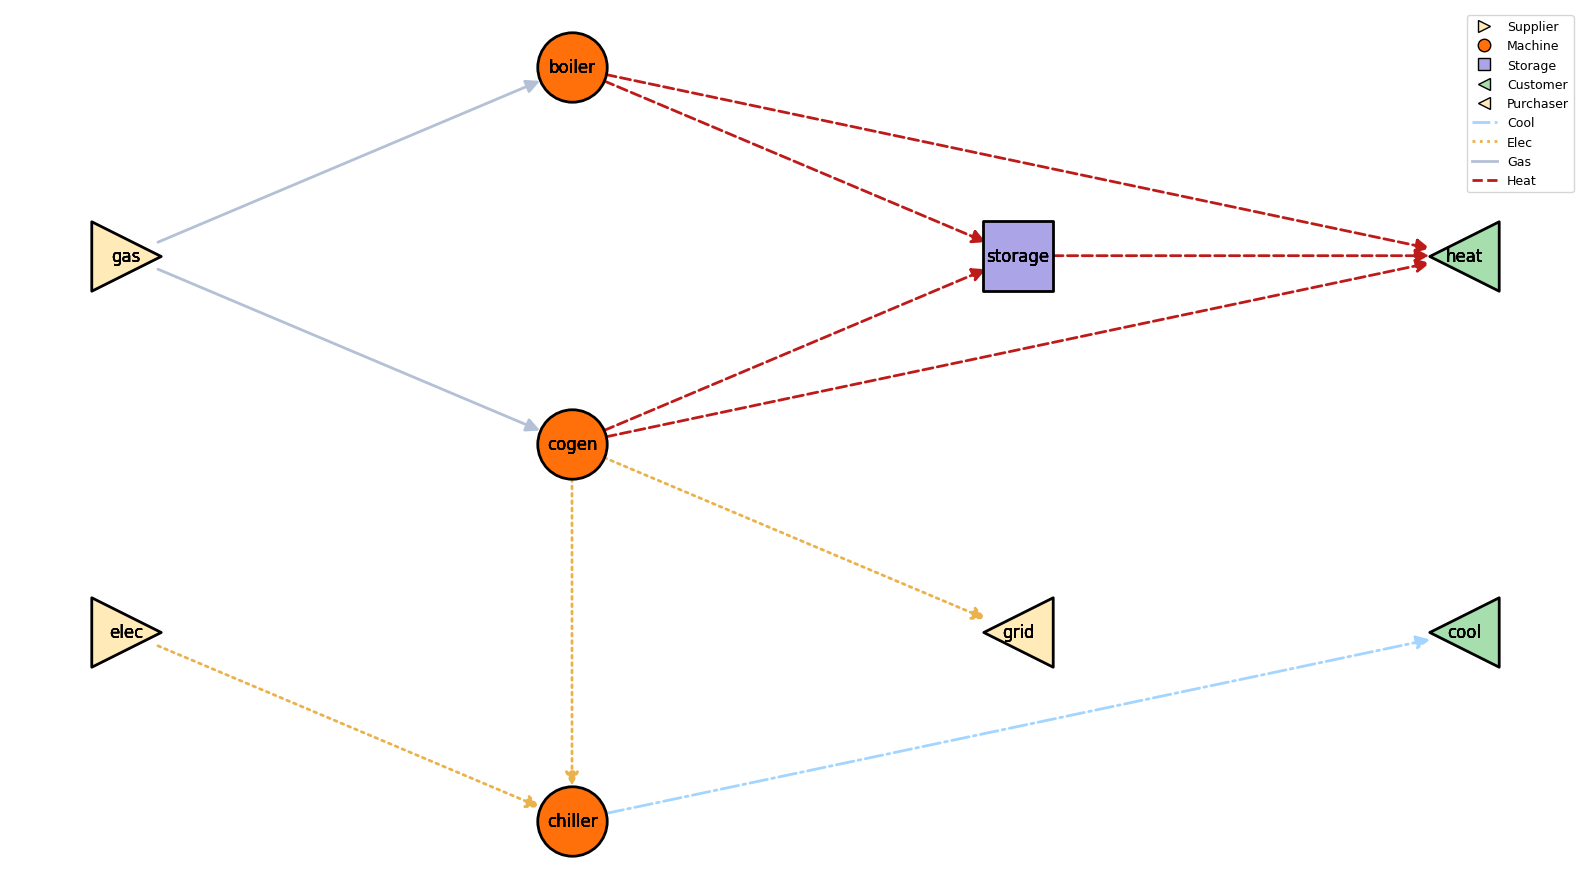

In [15]:
plant.draw(
    figsize=(16, 9),
    legend=9,
    node_size=25,
    node_pos=[
        ['gas', 'elec'],
        ['boiler', 'cogen', 'chiller'],
        ['storage', 'grid'],
        ['heat', 'cool']
    ],
    edge_colors={'gas': '#B4C0D5', 'heat': '#BD1B19', 'elec': '#EBB14A', 'cool': '#A3D5FF'},
    edge_styles={'gas': 'solid', 'heat': 'dashed', 'elec': 'dotted', 'cool': 'dashdot'}
)

## 4. Run the Simulation

As a final step, it is possible to run the simulation using the `run` method.

This method accepts two input parameters:
* `plan`, i.e., a dictionary of type {`machine` | `edge`: `states` | `flows`} which associates to each a vector of states for each machine and a vector of flows for each edge in the plant.
* `action`, i.e., a `RecourseAction` object that defines the strategy to update the states and the flows throughout the simulation. In this case, we are using the default implementation of the recourse action, which computes the new flows using a greedy strategy that minimizes at each time step the distance from the given plan.
A callback mechanism is also implemented, and allows to keep track of the internal status of the simulation by passing a custom `Callback` object to the `callbacks` method.

> Note: as for the vector of predictions, again passing a single float value will be translated in a constant vector. Also, the value `np.nan` indicates that the machine is off in that specific time step.

In [16]:
from powerplantsim.plant import DefaultRecourseAction

output = plant.run(
    plan={
        'boiler': [0.1, 0.4, 0.2, 0.4, 0.6, 0.6, 0.5],
        'cogen': [np.nan, 0.5, np.nan, np.nan, np.nan, 1.0, np.nan],
        'chiller': 0.6,
        ('gas', 'boiler'): [10, 40, 20, 40, 60, 60, 50],
        ('gas', 'cogen'): [0, 67.5, 0, 0, 0, 135, 0],
        ('elec', 'chiller'): 0.42,
        ('boiler', 'storage'): 0.0,
        ('boiler', 'heat'): [9, 36, 18, 36, 54, 54, 45],
        ('cogen', 'storage'): 0.0,
        ('cogen', 'chiller'): 0.0,
        ('cogen', 'heat'): [0, 27, 0, 0, 0, 50, 0],
        ('cogen', 'grid'): [0, 23, 0, 0, 0, 50, 0],
        ('storage', 'heat'): 0.0,
        ('chiller', 'cool'): 1.2
    },
    action=DefaultRecourseAction(solver='gurobi'),
    callbacks=None
)

Simulation Status: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


The `run` method return a `SimulationOutput` object, which contains all the simulation details such as the actual machine states that were used, the actual flows that passed in all the edges, and the actual prices, demands, and storage values.

In [17]:
output.states

,boiler,chiller,cogen
0,0.000000,0.386790,1.0
1,0.600000,0.346433,NaN
2,0.646667,0.494708,NaN
3,0.000000,0.337673,1.0
4,0.574733,0.378121,NaN
5,0.551111,0.345574,NaN
6,0.020000,0.504251,1.0


In [18]:
output.flows

,"(gas, cogen)","(storage, heat)","(elec, chiller)","(cogen, chiller)","(chiller, cool)","(gas, boiler)","(boiler, storage)","(cogen, grid)","(boiler, heat)","(cogen, heat)","(cogen, storage)"
0,135.0,0.000,0.270753,0.000000,0.773579,0.000000,0.0,50.000000,0.000,50.0,0.0
1,0.0,0.000,0.242503,0.000000,0.692866,60.000000,0.0,0.000000,54.000,0.0,0.0
2,0.0,0.000,0.346296,0.000000,0.989416,64.666667,0.0,0.000000,58.200,0.0,0.0
3,135.0,0.000,0.000000,0.236371,0.675345,0.000000,0.0,49.763629,0.000,48.7,1.3
4,0.0,1.274,0.264685,0.000000,0.756242,57.473333,0.0,0.000000,51.726,0.0,0.0
5,0.0,0.000,0.241902,0.000000,0.691148,55.111111,0.0,0.000000,49.600,0.0,0.0
6,135.0,0.000,0.352976,0.000000,1.008503,2.000000,0.0,50.000000,1.800,50.0,0.0


In [19]:
pd.concat([output.storage, output.demands, output.buying_prices, output.sell_prices],
          keys=['storage', 'demands', 'buying_prices', 'sell_prices'], axis=1)

storage   demands       buying_prices sell_prices          
  storage      cool  heat          grid         gas      elec
0     0.0  0.773579  50.0      2.320211         1.0  1.425146
1     0.0  0.692866  54.0      2.180798         1.0  0.820980
2     0.0  0.989416  58.2      1.648132         1.0  2.560800
3     1.3  0.675345  48.7      2.020663         1.0  2.946916
4     0.0  0.756242  53.0      1.377045         1.0  1.334994
5     0.0  0.691148  49.6      1.841850         1.0  1.953547
6     0.0  1.008503  51.8      1.935733         1.0  1.582326